In [1]:
# read driving_log in as pandas.dataframe
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

datapath = 'data_given/'
data = pd.read_csv(datapath + 'driving_log.csv',delimiter=',')


In [32]:
data['right'][ind].strip()

'IMG/right_2016_12_01_13_33_22_922.jpg'

In [38]:
import cv2

def filpcolor(srcBGR):
    destRGB = cv2.cvtColor(srcBGR, cv2.COLOR_BGR2RGB)
    return destRGB

ind = np.random.randint(len(data))
image_left=filpcolor(cv2.imread(datapath + data['left'][ind].strip()))
image_center=filpcolor(cv2.imread(datapath + data['center'][ind].strip()))
image_right=filpcolor(cv2.imread(datapath + data['right'][ind].strip()))


(160, 320, 3)


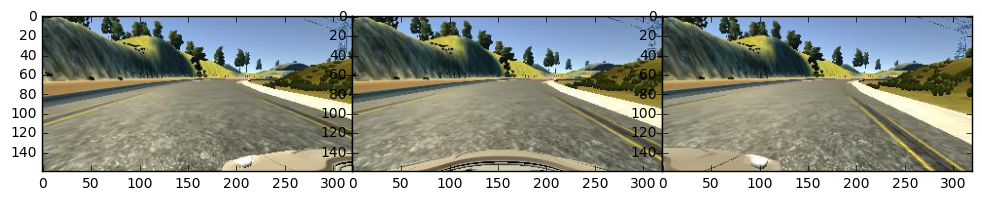

In [41]:
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import gridspec
plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1, 3,hspace=0,wspace=0) 
plt.subplot(gs[0])
plt.imshow(image_left)
plt.subplot(gs[1])
plt.imshow(image_center)
plt.subplot(gs[2])
plt.imshow(image_right)
print(image_center.shape)

In [ ]:
rows,cols,cha = image.shape
tr_x = trans_range*np.random.uniform()-trans_range/2
steer_ang = steer + tr_x/trans_range*2*.2
tr_y = 40*np.random.uniform()-40/2
#tr_y = 0
Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))


In [3]:
# data augmentation
# 1. Brightness augmentation
def brightness_jitter(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    bright_jitter_rate = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*bright_jitter_rate
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [4]:
# 2. Horizontal and vertical shifts
# We will shift the camera images horizontally to simulate the effect of car being at different positions on the road,
# and add an offset corresponding to the shift to the steering angle. We added 0.004 steering angle units per pixel 
# shift to the right, and subtracted 0.004 steering angle units per pixel shift to the left. We will also shift the 
# images vertically by a random number to simulate the effect of driving up or down the slope.
def steering_jitter(image,steer,trans_range):
    # Translation
    rows,cols,cha = image.shape  
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang

In [5]:
# 3. Shadow augmentation
# The next augmentation we will add is shadow augmentation where random shadows are cast across the image. 
# This is implemented by choosing random points and shading all points on one side (chosen randomly) of the image. 
# The code for this augmentation is presented below.
def shadow_jitter(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

In [6]:
new_size_col,new_size_row=64,64
def preprocessImage(image):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(new_size_col,new_size_row),interpolation=cv2.INTER_AREA)    
    #image = image/255.-.5
    return image
def preprocess_image_file_train(line_data):
    i_lrc = np.random.randint(3)
    if (i_lrc == 0):
        path_file = line_data['left'][0].strip()
        shift_ang = .25
    if (i_lrc == 1):
        path_file = line_data['center'][0].strip()
        shift_ang = 0.
    if (i_lrc == 2):
        path_file = line_data['right'][0].strip()
        shift_ang = -.25
    y_steer = line_data['steering'][0] + shift_ang
    image = cv2.imread(datapath+path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image,y_steer = steering_jitter(image,y_steer,100)
    image = brightness_jitter(image)
    image = shadow_jitter(image)
    image = preprocessImage(image)
    image = np.array(image)
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = -y_steer
    
    return image,y_steer

In [7]:
# We will utilize kera’s generator function to sample images such that images with 
# lower angles have lower probability of getting represented in the data set.
def generate_train_from_PD_batch(data,batch_size = 32):
    
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            
            keep_pr = 0
            #x,y = preprocess_image_file_train(line_data)
            while keep_pr == 0:
                x,y = preprocess_image_file_train(line_data)
                pr_unif = np.random
                if abs(y)<.1:
                    pr_val = np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            
            #x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            #y = np.array([[y]])
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering
    return batch_images, batch_steering

In [8]:
# construct model
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, Input, Dropout, MaxPooling2D, Activation
from keras.models import model_from_json
from keras.activations import relu, softmax

model = Sequential()
model.add(Convolution2D(24, 5, 5,input_shape=(64, 64, 3),subsample = (2,2)))
model.add(Activation('relu'))
# (32, 30, 30, 24)
model.add(Convolution2D(36, 5, 5,subsample = (2,2)))
model.add(Activation('relu'))
# (32, 13, 13, 36)
model.add(Convolution2D(48, 5, 5,subsample = (2,2)))
model.add(Activation('relu'))
# (32, 5, 5, 48)
model.add(Convolution2D(64, 3, 3,subsample = (1,1)))
model.add(Activation('relu'))
# (32, 3, 3, 64)
model.add(Convolution2D(96, 3, 3,subsample = (1,1)))
model.add(Activation('relu'))
# (32, 1, 1, 96)
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))
# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
# Fit the model

Using TensorFlow backend.


In [9]:
# train
# data is panda’s dataframe that has path to the image files and steering data
import numpy as np

val_size = 1 
pr_threshold = 1
batch_size = 256
for i_pr in range(8):
    train_r_generator = generate_train_from_PD_batch(data,batch_size)
    
    nb_vals = np.round(len(data)/val_size)-1
    model.fit_generator(train_r_generator,samples_per_epoch=20000, nb_epoch=1,verbose=1)
    pr_threshold = 1/(i_pr+1)*1

Epoch 1/1
20224/20000 [==============================] - 129s - loss: 0.3843 - mean_squared_error: 0.3843   

/home/microway/anaconda3/envs/TensorFlowGPU/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 1/1
20224/20000 [==============================] - 129s - loss: 0.0565 - mean_squared_error: 0.0565   
Epoch 1/1
20224/20000 [==============================] - 113s - loss: 0.0507 - mean_squared_error: 0.0507   
Epoch 1/1
20224/20000 [==============================] - 108s - loss: 0.0442 - mean_squared_error: 0.0442   
Epoch 1/1
20224/20000 [==============================] - 106s - loss: 0.0419 - mean_squared_error: 0.0419   
Epoch 1/1
20224/20000 [==============================] - 105s - loss: 0.0398 - mean_squared_error: 0.0398   
Epoch 1/1
20224/20000 [==============================] - 104s - loss: 0.0374 - mean_squared_error: 0.0374   
Epoch 1/1
20224/20000 [==============================] - 103s - loss: 0.0359 - mean_squared_error: 0.0359   


In [10]:
from keras.models import load_model
model.save('model2.h5')

In [ ]:
from keras.models import model_from_json
import numpy
import os


model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [1]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

Using TensorFlow backend.


In [19]:
import numpy as np
# evaluate loaded model on test data
X=preprocessImage(image)
X=X.reshape((1,)+X.shape)
Y=np.array(1)
Y=Y.reshape((1,))

In [23]:
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
y_new = loaded_model.predict(X)
y_new

array([[ 4.17965031]], dtype=float32)

In [ ]:
# keras save and reuse model: http://machinelearningmastery.com/save-load-keras-deep-learning-models/
# MLP for Pima Indians Dataset serialize to JSON and HDF5
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset
dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, init='uniform', activation='relu'))
model.add(Dense(12, input_dim=8, init='uniform', activation='relu'))
model.add(Dense(8, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X, Y, nb_epoch=150, batch_size=10, verbose=0)
# evaluate the model
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# later...

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print "%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100)

In [ ]:




"""
Steering angle prediction model
"""
import os
import argparse
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D

from server import client_generator


def gen(hwm, host, port):
  for tup in client_generator(hwm=hwm, host=host, port=port):
    X, Y, _ = tup
    Y = Y[:, -1]
    if X.shape[1] == 1:  # no temporal context
      X = X[:, -1]
    yield X, Y


def get_model(time_len=1):
  ch, row, col = 3, 160, 320  # camera format

  model = Sequential()
  model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(ch, row, col),
            output_shape=(ch, row, col)))
  model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
  model.add(ELU())
  model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
  model.add(ELU())
  model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
  model.add(Flatten())
  model.add(Dropout(.2))
  model.add(ELU())
  model.add(Dense(512))
  model.add(Dropout(.5))
  model.add(ELU())
  model.add(Dense(1))

  model.compile(optimizer="adam", loss="mse")

  return model


if __name__ == "__main__":
  parser = argparse.ArgumentParser(description='Steering angle model trainer')
  parser.add_argument('--host', type=str, default="localhost", help='Data server ip address.')
  parser.add_argument('--port', type=int, default=5557, help='Port of server.')
  parser.add_argument('--val_port', type=int, default=5556, help='Port of server for validation dataset.')
  parser.add_argument('--batch', type=int, default=64, help='Batch size.')
  parser.add_argument('--epoch', type=int, default=200, help='Number of epochs.')
  parser.add_argument('--epochsize', type=int, default=10000, help='How many frames per epoch.')
  parser.add_argument('--skipvalidate', dest='skipvalidate', action='store_true', help='Multiple path output.')
  parser.set_defaults(skipvalidate=False)
  parser.set_defaults(loadweights=False)
  args = parser.parse_args()

  model = get_model()
  model.fit_generator(
    gen(20, args.host, port=args.port),
    samples_per_epoch=10000,
    nb_epoch=args.epoch,
    validation_data=gen(20, args.host, port=args.val_port),
    nb_val_samples=1000
  )
  print("Saving model weights and configuration file.")

  if not os.path.exists("./outputs/steering_model"):
      os.makedirs("./outputs/steering_model")

  model.save_weights("./outputs/steering_model/steering_angle.keras", True)
  with open('./outputs/steering_model/steering_angle.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)